# <center>Project 2: Gun Analysis in California<br><span style="font-size: 12px">Udacity Data Analytic Nanodegree Project 2 - Investigate a Dataset</span></center>

## Table of Contents<a id='toc'></a>
* <a href="#intro">Introduction</a>
* <a href="#wrangling">Data Wrangling</a>
    * <a href="#f1">Data Cleaning File 'gun_data.xlsx'</a>
    * <a href="#f2">Data Cleaning File 'U.S. Census Data.csv'</a>  
* <a href="#eda">Exploratory Data Analysis</a>
    * <a href="#q1">Q1: How Many Permits are Issued for Each Type of Gun in California?</a>
    * <a href="#q2">Q2: What is the trend of gun permit and background checks in California?</a>
    * <a href="#q3">Q3: How is The Growth of Gun Permit  in Relationship to the Growth of The Population?</a>
* <a href="#conclusions">Conclusions</a>
* <a href="#resources">Resources</a>

## Introduction <a id='intro'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

The goal of this analysis is to take a deeper look into the gun permits issuing in California and whether it is related to the growth of the population. For this analysis, two datasets are used:
1. 'gun_data.xlsx': This data comes from the FBI's National Instant Criminal Background Check System (NICS). It is used to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. It contains the number of firearm checks by month, state, and type.
2. 'U.S. Census Data.csv': This is the U.S. census data. It contains several variables at the state level.

**Analysis Questions**
1. How Many Permits are Issued for Each Type of Gun in California?
2. What is the trend of gun permit and background checks in California?
3. How is The Growth of Gun Permit  in Relationship to the Growth of The Population?

## Data Wrangling <a id='wrangling'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [387]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data Cleaning File 'gun_data.xlsx' <a id="f1"></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [388]:
def get_gun_data():
    # Read in NICS data and convert dates to datetime object
    df_guns = pd.read_excel('gun_data.xlsx', parse_dates=[0])
    
    # Selecte only interested columns and row for "Californa"
    df_guns_cal = df_guns.iloc[:, [0,1,2,4,5,6,7,26]]
    df_guns_cal = df_guns_cal.loc[df_guns.state == 'California']

    df_guns_cal.reset_index(inplace=True, drop=True)
    
    # Convert 'tatals' column to float datatype
    df_guns_cal['totals'] = df_guns_cal['totals'].astype(float)
    
    return df_guns_cal

In [389]:
df_guns_cal = get_gun_data()
df_guns_cal.head(3)

,month,state,permit,handgun,long_gun,other,multiple,totals
0,2017-09-01,California,57839.0,37165.0,24581.0,2984.0,0,123506.0
1,2017-08-01,California,59528.0,41110.0,26220.0,3058.0,0,130901.0
2,2017-07-01,California,52610.0,37027.0,21721.0,2514.0,0,114595.0


### Data Cleaning File 'U.S. Census Data.csv' <a id="f2"></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [390]:
def get_census_data():
    df_census = pd.read_csv('U.S. Census Data.csv')
    
    # Select census data for California
    df_census_cal = df_census.loc[:, ['Fact','California']]
    
    # Remove rows with NaN
    df_census_cal.dropna(inplace=True)
    
    # Select only rows contain population
    df_census_cal_pop = df_census_cal.loc[
        df_census_cal.Fact.str.contains('Population estimates') | 
        df_census_cal.Fact.str.contains('Population, Census')].copy(deep=True)
    df_census_cal_pop.reset_index(inplace=True, drop=True)
    
    # Add a column for date
    mask = df_census_cal_pop.Fact.str.contains('July 1, 2016')
    df_census_cal_pop.loc[mask, 'date'] = datetime.datetime(2016, 7, 1)
    mask = df_census_cal_pop.Fact.str.contains('April 1, 2010')
    df_census_cal_pop.loc[mask, 'date'] = datetime.datetime(2010, 4, 1)
    
    # Change the number strings to float
    df_census_cal_pop['California'] = df_census_cal_pop['California'].str.replace(',','')
    df_census_cal_pop['California'] = df_census_cal_pop['California'].str.replace('%','')
    df_census_cal_pop['California'] = df_census_cal_pop.California.astype('float')

    return df_census_cal_pop

In [391]:
df_census_cal_pop = get_census_data()
df_census_cal_pop.head(3)

,Fact,California,date
0,"Population estimates, July 1, 2016, (V2016)",39250017.0,2016-07-01
1,"Population estimates base, April 1, 2010, (V2...",37254522.0,2010-04-01
2,"Population, Census, April 1, 2010",37253956.0,2010-04-01


## Exploratory Data Analysis <a id='eda'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

### Q1: How Many Permits are Issued for Each Type of Gun in California? <a id="q1"></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [392]:
def clean_gun_for_analysis(df):
    df_guns_cal = df
    
    # Remove year 2017 rows, it doesn't contain a full year data; contain only up to September 2017
    rows_2017 = df_guns_cal[df_guns_cal.month.dt.year == 2017].index
    df_guns_cal.drop(rows_2017, inplace=True)

    # Remove year 1998 rows, it doesn't contain a full year data; only contain Nov and Dec data
    rows_1998 = df_guns_cal[df_guns_cal.month.dt.year == 1998].index
    df_guns_cal.drop(rows_1998, inplace=True)
    
    # Rename column 'totals' to 'background_check'
    df_guns_cal.columns = ['month', 'state', 'permit', 'handgun', 
                           'long gun', 'other', 'multiple', 'background check']
    
    # Fill NaN with mean
    df_guns_cal.other = df_guns_cal.other.fillna(df_guns_cal.other.mean())

    return df_guns_cal

In [393]:
df_guns_cal = clean_gun_for_analysis(df_guns_cal)

In [394]:
# Aggregate gun data by year
df_guns_grp = df_guns_cal.groupby([df_guns_cal['month'].dt.year.rename('year')]).sum().copy(deep=True)
df_guns_grp.reset_index(inplace=True)
df_guns_grp.head(3)

,year,permit,handgun,long gun,other,multiple,background check
0,1999,101132.0,371893.0,410119.0,41752.615385,0,883144.0
1,2000,163145.0,328615.0,302746.0,41752.615385,0,794506.0
2,2001,236271.0,280044.0,338251.0,41752.615385,0,854569.0


In [395]:
# Average gun data for each year
df_guns_grp_mean = df_guns_cal.groupby([df_guns_cal['month'].dt.year.rename('year')]).mean()
df_guns_grp_mean.head(3)

,permit,handgun,long gun,other,multiple,background check
year,,,,,,
1999,8427.666667,30991.083333,34176.583333,3479.384615,0.0,73595.333333
2000,13595.416667,27384.583333,25228.833333,3479.384615,0.0,66208.833333
2001,19689.250000,23337.000000,28187.583333,3479.384615,0.0,71214.083333


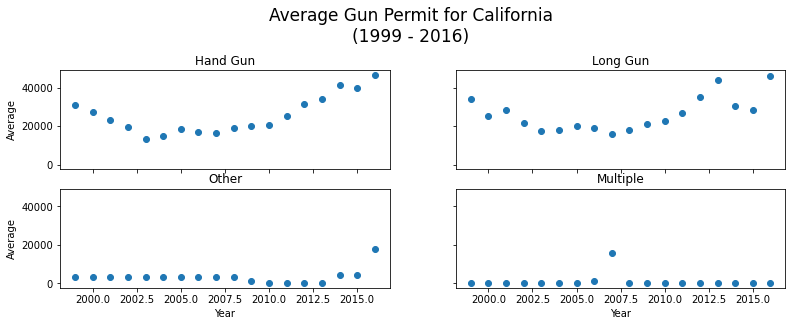

In [396]:
# Explore individual types of gun
fig , [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(13,4), 
                                              sharey=True, sharex=True)

titles = ['Average Gun Permit for California', '(1999 - 2016)']
fig.suptitle('\n'.join(titles), y=1.1, fontsize=17)

x = df_guns_grp_mean.index

y = df_guns_grp_mean.handgun
ax1.scatter(x, y);
ax1.set_title('Hand Gun');
ax1.set_ylabel('Average');

y = df_guns_grp_mean['long gun']
ax2.scatter(x, y);
ax2.set_title('Long Gun');

y = df_guns_grp_mean['other']
ax3.scatter(x, y);
ax3.set_title('Other');
ax3.set_ylabel('Average');
ax3.set_xlabel('Year');

y = df_guns_grp_mean['multiple']
ax4.scatter(x, y);
ax4.set_title('Multiple');
ax4.set_xlabel('Year');

<center style="display:inline-block; padding-left:55px"><i style="color: blue">The reason for this graph is to look at the trend of gun permit for each type of guns over the 17 years period.</i></center>

In [397]:
# Explore average gun permit distribution
df_guns_grp_mean.permit.describe()

count       18.000000
mean     27747.069444
std      21118.520953
min       8427.666667
25%      13787.229167
50%      23184.625000
75%      27700.187500
max      86415.083333
Name: permit, dtype: float64

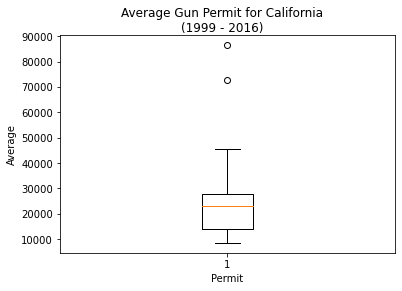

In [398]:
# Plotting average gun permit distribution
fig , ax = plt.subplots()

titles = ['Average Gun Permit for California', '(1999 - 2016)']
fig.suptitle('\n'.join(titles))

y = df_guns_grp_mean.permit
ax.boxplot(y);
ax.set_xlabel('Permit');
ax.set_ylabel('Average');


<i style="color: blue">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The reason for this graph is to look at the distribution of gun permit.</i>

In [399]:
# Explore average background check distribution
df_guns_grp_mean['background check'].describe()

count        18.000000
mean      82310.601852
std       39974.331041
min       43702.583333
25%       59032.666667
50%       69623.666667
75%       89656.458333
max      198097.250000
Name: background check, dtype: float64

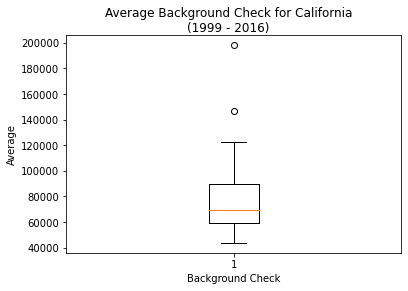

In [422]:
# Plotting average background check distribution
fig , ax = plt.subplots()

titles = ['Average Background Check for California', '(1999 - 2016)']
fig.suptitle('\n'.join(titles))

y = df_guns_grp_mean['background check']
ax.boxplot(y);
ax.set_xlabel('Background Check');
ax.set_ylabel('Average');

<i style="color: blue">&nbsp;&nbsp;&nbsp;The reason for this graph is to look at the distribution of background check.</i>

In [401]:
# Change the dataframe to a long form for plotting
df_guns_melted = pd.melt(df_guns_grp, id_vars=["year"], value_vars=['handgun', 'long gun', 'other', 'multiple'],
                        var_name='types', value_name='total')
df_guns_melted.head(3)

,year,types,total
0,1999,handgun,371893.0
1,2000,handgun,328615.0
2,2001,handgun,280044.0


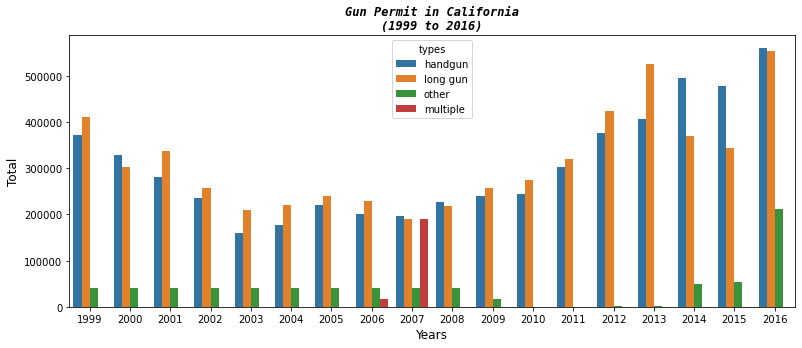

In [423]:
fig , ax = plt.subplots(figsize=(13,5))
sns.barplot(data=df_guns_melted, y='total', x='year', hue='types', ax=ax);

title = ['Gun Permit in California', '(1999 to 2016)',]
ax.set_title(
    '\n'.join(title),
    fontsize='large',
    loc='center',
    fontweight='bold',
    style='italic',
    family='monospace');

ax.set_xlabel(
    'Years', 
    fontsize='large');

ax.set_ylabel(
    'Total', 
    fontsize='large');

<center style="display:inline-block; padding-left:55px"><i style="color: blue">The reason for this graph is to compare the trend of different gun types over the 17 years timeframe.</i></center>

### Q2: What is the trend of gun permit and background checks in California? <a id='q2'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [403]:
# Melt permit and background checks for plotting
df_permit_melted = pd.melt(df_guns_grp, id_vars=["year"], value_vars=['permit', 'background check'],
                        var_name='types', value_name='total')
df_permit_melted.head(3)

,year,types,total
0,1999,permit,101132.0
1,2000,permit,163145.0
2,2001,permit,236271.0


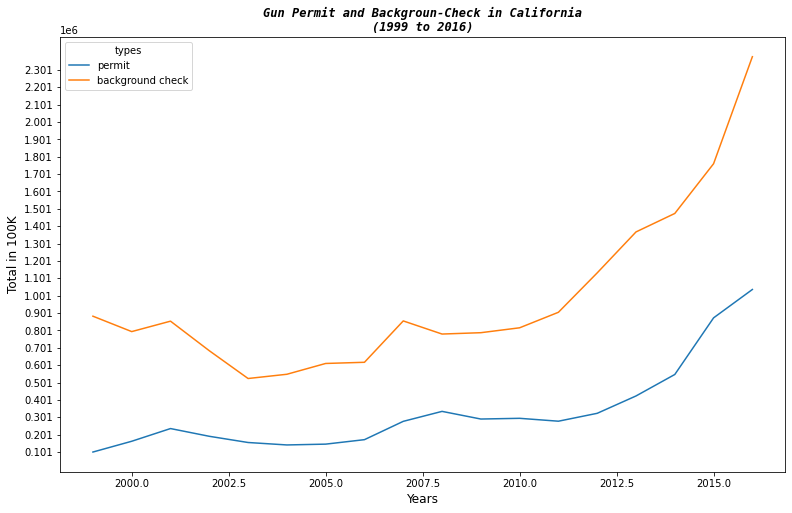

In [404]:
# Plotting for permits and background check
fig , ax = plt.subplots(figsize=(13,8))
sns.lineplot(data=df_permit_melted, y='total', x='year', hue='types', ax=ax);

ax.set_title(
    "Gun Permit and Backgroun-Check in California\n(1999 to 2016)",
    fontsize='large',
    loc='center',
    fontweight='bold',
    style='italic',
    family='monospace')
    
ax.set_xlabel(
    'Years', 
    fontsize='large')

ax.set_ylabel(
    'Total in 100K', 
    fontsize='large')

t = np.arange(df_permit_melted.total.min(), df_permit_melted.total.max(), 100000)
ax.set_yticks(t);

<center style="display:inline-block; padding-left:55px"><i style="color: blue">The reason for this graph is to compare the trend of gun permit in relate to background check.<br>This can be infer that multiple transactions take place with each permit.</i></center>

### Q3: How is The Growth of Gun Permit  in Relationship to the Growth of The Population? <a id="q3"></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

In [405]:
# California census data
df_census_cal_pop.head(3)

,Fact,California,date
0,"Population estimates, July 1, 2016, (V2016)",39250017.0,2016-07-01
1,"Population estimates base, April 1, 2010, (V2...",37254522.0,2010-04-01
2,"Population, Census, April 1, 2010",37253956.0,2010-04-01


In [406]:
# Select population data for two months (07/2016, and 4/2010)
df_pop_2mons = df_census_cal_pop.iloc[[0,2],:]
df_pop_2mons.columns = ['fact', 'population', 'month']
df_pop_2mons

,fact,population,month
0,"Population estimates, July 1, 2016, (V2016)",39250017.0,2016-07-01
2,"Population, Census, April 1, 2010",37253956.0,2010-04-01


In [407]:
# California gun data
df_guns_cal.head(3)

,month,state,permit,handgun,long gun,other,multiple,background check
9,2016-12-01,California,61808.0,63649.0,93224.0,77929.0,0,298161.0
10,2016-11-01,California,53278.0,56932.0,82554.0,30133.0,0,224039.0
11,2016-10-01,California,60578.0,45785.0,54333.0,19226.0,0,180968.0


In [408]:
# Select gun data for the same two months (07/2016, and 4/2010) to compare with the population
df_rel = df_guns_cal.loc[(df_guns_cal.month=='2016-07-01') | (df_guns_cal.month=='2010-04-01')]
df_rel

,month,state,permit,handgun,long gun,other,multiple,background check
14,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0
89,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0


In [409]:
# Merge the gun data and popolation data
df_merged = pd.merge(df_rel, df_pop_2mons, on='month')
df_merged

,month,state,permit,handgun,long gun,other,multiple,background check,fact,population
0,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0,"Population estimates, July 1, 2016, (V2016)",39250017.0
1,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0,"Population, Census, April 1, 2010",37253956.0


In [410]:
# Drop column 'fact'
df_merged.drop(['fact'], axis=1, inplace=True)
df_merged

,month,state,permit,handgun,long gun,other,multiple,background check,population
0,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0,39250017.0
1,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0,37253956.0


In [411]:
# Add base columns for permit, backgroud check and population to compare changes from April 2010 to July 2016
df_merged['base permit'] = float(df_merged.loc[df_merged.month == '2010-04-01'].permit)
df_merged['base bg-check'] = float(df_merged.loc[df_merged.month == '2010-04-01']['background check'])
df_merged['base population'] = float(df_merged.loc[df_merged.month == '2010-04-01'].population)
df_merged

,month,state,permit,handgun,long gun,other,multiple,background check,population,base permit,base bg-check,base population
0,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0,39250017.0,26930.0,80750.0,37253956.0
1,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0,37253956.0,26930.0,80750.0,37253956.0


In [412]:
# Calculate the percent changes
df_merged['chng permit'] = (df_merged['permit'] - df_merged['base permit']) / df_merged['base permit'] * 100
df_merged['chng bg-check'] = (df_merged['background check'] - df_merged['base bg-check']) / df_merged['base bg-check'] * 100
df_merged['chng population'] = (df_merged['population'] - df_merged['base population']) / df_merged['base population'] * 100
df_merged

,month,state,permit,handgun,long gun,other,multiple,background check,population,base permit,base bg-check,base population,chng permit,chng bg-check,chng population
0,2016-07-01,California,77962.0,46361.0,47594.0,17297.0,0,190218.0,39250017.0,26930.0,80750.0,37253956.0,189.4987,135.564087,5.357984
1,2010-04-01,California,26930.0,26170.0,27650.0,0.0,0,80750.0,37253956.0,26930.0,80750.0,37253956.0,0.0000,0.000000,0.000000


In [413]:
# Melt the data for plotting
df_rel_melted = pd.melt(df_merged, id_vars=["month"], value_vars=['chng permit', 'chng bg-check','chng population'],
                        var_name='types', value_name='percent').copy(deep=True)
df_rel_melted.sort_values(by=['month'], inplace=True)
df_rel_melted

,month,types,percent
1,2010-04-01,chng permit,0.000000
3,2010-04-01,chng bg-check,0.000000
5,2010-04-01,chng population,0.000000
0,2016-07-01,chng permit,189.498700
2,2016-07-01,chng bg-check,135.564087
4,2016-07-01,chng population,5.357984


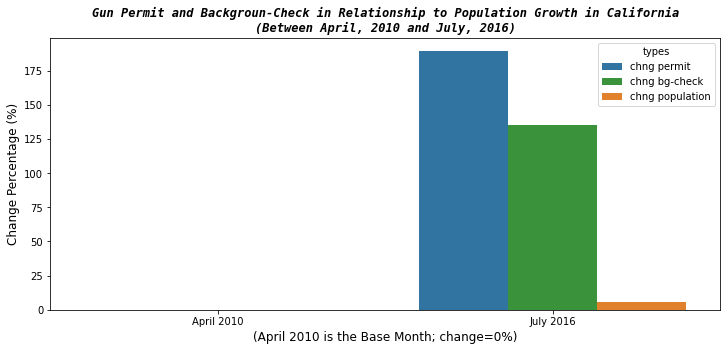

In [414]:
# Plotting changes from moth April 2010 to July 2016
titles = ['Gun Permit and Backgroun-Check in Relationship to Population Growth in California', '(Between April, 2010 and July, 2016)']
data = df_rel_melted

palette = {
    'chng permit': 'tab:blue',
    'chng bg-check': 'tab:green',
    'chng population': 'tab:orange',
}

fig , ax = plt.subplots(figsize=(12,5))
sns.barplot(data=data, y='percent', x='month', hue='types', ax=ax, palette=palette);

ax.set_title(
    '\n'.join(titles),
    fontsize='large',
    loc='center',
    fontweight='bold',
    style='italic',
    family='monospace')

ax.set_xlabel(
    '(April 2010 is the Base Month; change=0%)', 
    fontsize='large')

ax.set_ylabel(
    'Change Percentage (%)', 
    fontsize='large')

ax.set_xticklabels(['April 2010', 'July 2016']);


<center style="display:inline-block; padding-left:55px"><i style="color: blue">The reason for this graph is to visualize the changes between April 2010 and July 2016 in term of population,<br>gun permit, and background check. (April 2010 is the base year, therefore it's zero change).</i></center>

## Conclusions <a id='conclusions'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

### Limitation
There are some limitation on this analysis. Due to the census data provides only two data point for the population (April 01, 2010 and July 01, 2016). There is a big data gap between April 2010 to July 2016. Hence, the population data from April 01, 2010 is established as the base, and the percent changes is calculated between the population from July 01, 2016 and the base. 

### Summary

><div style="font-weight:bold; color:#1976d2">1. In California, gun permit has rapidly increased by 272.18% since 2011.</div>

In [420]:
# Calculate the change from 2011 to 2016
permit_2011 = float(df_permit_melted[(df_permit_melted.types == 'permit') & (df_permit_melted.year == 2011)].total)
permit_2016 = float(df_permit_melted[(df_permit_melted.types == 'permit') & (df_permit_melted.year == 2016)].total)
change_prct = (permit_2016 - permit_2011) / permit_2011 * 100
change_prct

272.1780170480036

><div style="font-weight:bold; color:#1976d2">2. On average, there are more permits for long gun then handgun. However, it is not consistent from year to year. In some years, there are more permits for hand gun then long gun; in other years, there are more permits for long gun then hand gun.</div>

In [421]:
# Calculate the average for different types of guns
mean_guns = df_guns_melted.groupby('types').total.mean()

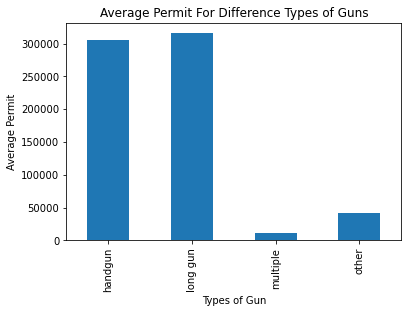

In [417]:
# Plotting the average of difference types of gun
mean_guns.plot(kind='bar');
plt.title('Average Permit For Difference Types of Guns');
plt.ylabel('Average Permit');
plt.xlabel('Types of Gun');

<div style="display:inline-block; padding-left:55px "><center><i style="color: blue">The reason for this graph is to visualize which<br>
    type of guns is more popular on average over the 17 years.</i></center></div>

><div style="font-weight:bold; color:#1976d2">3. There is no strong evidence showing the growth of population in California caused the growth of gun permit. Between April 01, 2010 and July 01, 2016, while California population only increased by 5.38%, California gun permit increased by 189.50%</div

In [418]:
chngs = df_rel_melted[df_rel_melted.month == '2016-07-01']

,month,types,percent
0,2016-07-01,chng permit,189.498700
2,2016-07-01,chng bg-check,135.564087
4,2016-07-01,chng population,5.357984


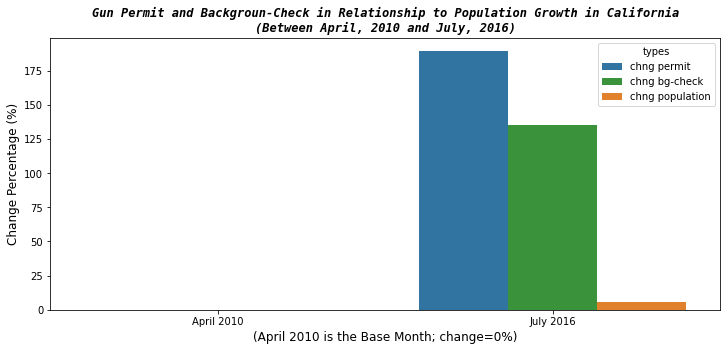

In [419]:
# Plotting changes from moth April 2010 to July 2016
titles = ['Gun Permit and Backgroun-Check in Relationship to Population Growth in California', '(Between April, 2010 and July, 2016)']
data = df_rel_melted

palette = {
    'chng permit': 'tab:blue',
    'chng bg-check': 'tab:green',
    'chng population': 'tab:orange',
}

fig , ax = plt.subplots(figsize=(12,5))
sns.barplot(data=data, y='percent', x='month', hue='types', ax=ax, palette=palette);

ax.set_title(
    '\n'.join(titles),
    fontsize='large',
    loc='center',
    fontweight='bold',
    style='italic',
    family='monospace')

ax.set_xlabel(
    '(April 2010 is the Base Month; change=0%)', 
    fontsize='large')

ax.set_ylabel(
    'Change Percentage (%)', 
    fontsize='large')

ax.set_xticklabels(['April 2010', 'July 2016']);

<div style="display:inline-block; padding-left:55px "><center><i style="color: blue">The reason for this graph is to visualize the changes between April 2010 and July 2016 in term of population,<br>gun permit, and background check. (April 2010 is the base year, therefore it's zero change).<br><br>
The correlation between the growth of population and the growth of gun permit is not that strong.</i></center></div>

## Resources <a id='resources'></a><a href="#toc"><span style="font-size: 12px">[TOC]</span></a>

1. [Panda Doc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.set_index.html)
2. [Seaborn Doc](https://seaborn.pydata.org/index.html)
3. [Matplotlib Doc](https://matplotlib.org/stable/plot_types/index.html)
4. [dev2qa.com](https://www.dev2qa.com/tag/python-pandas/)
5. [thoughtco](https://www.thoughtco.com/how-to-make-a-histogram-3126230)
6. [geeksforgeeks](https://www.geeksforgeeks.org/how-to-set-a-single-main-title-for-all-the-subplots-in-matplotlib/#:~:text=A%20title%20in%20matplotlib%20library%20describes%20the%20main,for%20all%20subplots%2C%20suptitle%20%28%29%20method%20is%20used.)
7. [stackoverflow](https://stackoverflow.com/)
8. [statology](https://www.statology.org/)